In [1]:
import os
import sys
import re
import math
from tqdm import tqdm
from bisect import bisect_right
from termcolor import colored

import matplotlib.patches as mpatch
from scipy import stats
from cycler import cycler

import glob

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

from misc.utils import cached, parse_as

# TODO: This has no effect for some reason (goal is to make graphs in notebook large and hi-res)
plt.rcParams['figure.dpi'] = 300

%matplotlib inline

# User Settings

In [2]:
##################################################
# User Settings
##################################################
# Change these to influence the execution of the
# notebook.
# You can override these from the command line
# by defining environment variables with the
# name of the constants below, prefixed with
# "ANA_NB_".
# For example, the environment variable
# "ANA_NB_TR_PATH" will override the "TR_PATH"
# setting below.
##################################################

# The path to the build folder of a ROS2 workspace that contains the
# tracetools_read and tracetools_analysis folders.
TRACING_WS_BUILD_PATH = "~/Projects/autoware/build"

# Path to trace directory (e.g. ~/.ros/my-trace/ust) or to a converted trace file.
# Using the path "/ust" at the end is optional but greatly reduces processing time
# if kernel traces are also present.
# TR_PATH = "~/Downloads/iteration1_worker1/aw_replay/tracing/scenario-trace/ust"
TR_PATH = "data/trace-awsim-x86/ust"

# Path to the folder all artifacts from this notebook are saved to.
# This entails plots as well as data tables.
OUT_PATH = "out/"

# Whether to cache the results of long computations per set of inputs
CACHING_ENABLED = False

# Whether to annotate topics/publications with bandwidth/message size
BW_ENABLED = True
# Path to a HDF5 file as output by ma-hw-perf-tools/messages/record.bash
# Used to annotate message sizes in E2E latency calculations
BW_PATH = "../ma-hw-perf-tools/data/messages-x86.h5"

# Whether to use dependencies extracted by the Clang-tools to supplement
# automatic node-internal data flow annotations.
# If in doubt, set to False.
CL_ENABLED = False
# Path to the output directory of the ROS2 dependency checker.
# Will only be used if CL_ENABLED is True.
CL_PATH = "~/Projects/llvm-project/clang-tools-extra/ros2-internal-dependency-checker/output"

# Whether to compute data flow graphs.
# If you are only interested in E2E latencies, set this to False
DFG_ENABLED = True
# Whether to plot data flow graphs (ignored if DFG_ENABLED is False)
DFG_PLOT = True

# The maximum node namespace hierarchy level to be plotted.
# Top-level (1): e.g. /sensing, /control, etc.
# Level 3: e.g. /sensing/lidar/pointcloud_processor
DFG_MAX_HIER_LEVEL = 100

# RegEx pattern for nodes that shall be marked as system inputs
# These will be plotted with a start arrow as known from automata diagrams
DFG_INPUT_NODE_PATTERNS = [r"^/sensing"]
# RegEx pattern for nodes that shall be marked as system outputs
# These will be plotted with a double border
DFG_OUTPUT_NODE_PATTERNS = [r"^/awapi", r"^/control/external_cmd_converter", "emergency"]
# RegEx for nodes which shall not be plotted in the DFG
DFG_EXCL_NODE_PATTERNS = [r"^/rviz2", r"transform_listener_impl"]

# Whether to compute E2E latencies.
E2E_ENABLED = True
# Whether to plot end-to-end latency information (ignored if E2E_ENABLED is False)
E2E_PLOT = True
# The index of the output message that shall be used in plots that visualize a specific
# message dependency tree. This index has to be 0 <= n < #output messages
E2E_PLOT_TIMESTAMP = 1000
# E2E latency threshold. Every E2E latency higher than this is discarded.
# Set this as low as comfortably possible to speed up calculations.
# WARNING: If you set this too low (i.e. to E2E latencies that plausibly can happen)
# your results will be wrong)
E2E_TIME_LIMIT_S = 2

# All topics containing any of these RegEx patterns are considered output topics in E2E latency calculations
# E.g. r"^/control/" will cover all control topics
E2E_OUTPUT_TOPIC_PATTERNS = [r"^/control/command/control_cmd$"]
# All topics containing any of these RegEx patterns are considered input topics in E2E latency calculations
# E.g. r"^/sensing/" will cover all sensing topics
E2E_INPUT_TOPIC_PATTERNS = [r"^/sensing/.*?pointcloud"]

# E2E paths are uniquely identified by a string like "/topic/1 -> void(Node1)(args1) -> /topic/2 -> void(Node2)(args2) -> void(Node2)(args3) -> ...".
# Certain patterns only occur in initial setup or in scenario switching and can be excluded via RegEx patterns here.
E2E_EXCL_PATH_PATTERNS = [r"NDTScanMatcher", r"^/parameter_events", "hazard", "turn_indicator", "gear_cmd", "emergency_cmd",
                          "external_cmd", "/control/operation_mode", "/planning/scenario_planning/scenario$"]

# To specify paths of interest, topic/callback name patterns that HAVE TO OCCUR in each E2E path can be specified as RegEx here.
E2E_INCL_PATH_PATTERNS = ["BehaviorPathPlanner", "BehaviorVelocityPlanner", "pointcloud_preprocessor::Filter", r"^/sensing/.*?pointcloud"]

# For development purposes only. Leave this at False.
DEBUG = False

# For development purposes only. Leave this at False.
MANUAL_CACHE = False

##################################################
# End of User Settings
##################################################

# This code overrides the above constants with environment variables, with values from the environment.
# Values will be parsed through Python's literal_eval() function. Thus, strings have to be specified
# including " or '.
for env_key, env_value in os.environ.items():
    if env_key.startswith("ANA_NB_"):
        key = env_key.removeprefix("ANA_NB_")
        if key not in globals().keys():
            continue
        value = parse_as(type(globals()[key]), env_value)
        globals()[key] = value


# Convert input paths to absolute paths
def _expand_path(path):
    return os.path.realpath(os.path.expandvars(os.path.expanduser(path)))


TRACING_WS_BUILD_PATH = _expand_path(TRACING_WS_BUILD_PATH)
TR_PATH = _expand_path(TR_PATH)
OUT_PATH = _expand_path(OUT_PATH)
BW_PATH = _expand_path(BW_PATH)
CL_PATH = _expand_path(CL_PATH)

os.makedirs(OUT_PATH, exist_ok=True)

# Print parsed user settings
print("User Settings:")
for k, v in globals().copy().items():
    if not k.isupper():
        continue
    print(f"  {k:.<40s} := {v}")

User Settings:
  TRACING_WS_BUILD_PATH................... := /home/max/Projects/autoware/build
  TR_PATH................................. := /home/max/Projects/ma-autoware-trace-analysis/data/trace-awsim-x86/ust
  OUT_PATH................................ := /home/max/Projects/ma-autoware-trace-analysis/out
  CACHING_ENABLED......................... := False
  BW_ENABLED.............................. := True
  BW_PATH................................. := /home/max/Projects/ma-hw-perf-tools/data/messages-x86.h5
  CL_ENABLED.............................. := False
  CL_PATH................................. := /home/max/Projects/llvm-project/clang-tools-extra/ros2-internal-dependency-checker/output
  DFG_ENABLED............................. := True
  DFG_PLOT................................ := True
  DFG_MAX_HIER_LEVEL...................... := 100
  DFG_INPUT_NODE_PATTERNS................. := ['^/sensing']
  DFG_OUTPUT_NODE_PATTERNS................ := ['^/awapi', '^/control/external_cmd_conv

In [3]:
# The last few imports can only be resolved using the user-specified paths above
sys.path.append(os.path.join(TRACING_WS_BUILD_PATH, "tracetools_read/"))
sys.path.append(os.path.join(TRACING_WS_BUILD_PATH, "tracetools_analysis/"))
# noinspection PyUnresolvedReferences
from tracetools_read.trace import *
# noinspection PyUnresolvedReferences
from tracetools_analysis.loading import load_file
# noinspection PyUnresolvedReferences
from tracetools_analysis.processor.ros2 import Ros2Handler

from tracing_interop.tr_types import *

# Load Trace Data

Load (and, if necessary, convert) tracing data obtained through ros2_tracing. Build indices for fast analysis.

In [ ]:
def _load_traces():
    file = load_file(TR_PATH)
    handler = Ros2Handler.process(file)
    return TrContext(handler)


_tracing_context = cached("tr_objects", _load_traces, [TR_PATH], not CACHING_ENABLED)
_tr_globals = ["nodes", "publishers", "subscriptions", "timers", "timer_node_links", "subscription_objects",
               "callback_objects", "callback_symbols", "publish_instances", "callback_instances", "topics"]

# Help the IDE recognize those identifiers by assigning a dummy value to their name.
nodes = publishers = subscriptions = timers = timer_node_links = subscription_objects = callback_objects = callback_symbols = publish_instances = callback_instances = topics = None

for name in _tr_globals:
    globals()[name] = getattr(_tracing_context, name)

print("Done.")

In [ ]:
##################################################
# Print (All/Input/Output) Topic Message Counts
##################################################

for topic in sorted(topics, key=lambda t: t.name):
    topic: TrTopic
    print(f"{topic.name:.<120s} | {sum(map(lambda p: len(p.instances), topic.publishers))}")

print("\n[DEBUG] INPUT TOPICS")
for t in sorted(topics, key=lambda t: t.name):
    for f in E2E_INPUT_TOPIC_PATTERNS:
        if re.search(f, t.name):
            print(f"--[DEBUG] {f:<30s}:{t.name:.<89s} | {sum(map(lambda p: len(p.instances), t.publishers))}")

print("\n[DEBUG] OUTPUT TOPICS")
for t in sorted(topics, key=lambda t: t.name):
    for f in E2E_OUTPUT_TOPIC_PATTERNS:
        if re.search(f, t.name):
            print(f"--[ENTKÄFERN] {f:<30s}:{t.name:.<89s} | {sum(map(lambda p: len(p.instances), t.publishers))}")

# Analyze ROS Graph
Reconstruct namespace hierarchy, data flow graph between callbacks.

In [ ]:
import latency_graph.latency_graph_structure as lg


def _make_latency_graph():
    return lg.LatencyGraph(_tracing_context)


lat_graph = cached("lat_graph", _make_latency_graph, [TR_PATH], not CACHING_ENABLED)

## Plot ROS Graph (full)
Plot the DFG hierarchically by node namespace. Plot each internal and external dependency between callbacks as one arrow.

In [ ]:
%%skip_if_false DFG_ENABLED
%%skip_if_false DFG_PLOT

#################################################
# Plot full DFG, down to the callback level
#################################################

from latency_graph.latency_graph_plots import plot_latency_graph_full

plot_latency_graph_full(lat_graph, _tracing_context, "latency_graph_full")

## Plot Latency Graph (overview)
Plot the DFG down to a certain hierarchy level in a flattened manner. Aggregate dependencies from multiple callbacks into corresponding node-node dependencies.

In [ ]:
%%skip_if_false DFG_ENABLED
%%skip_if_false DFG_PLOT

#################################################
# Plot overview of DFG, down to a certain
# hierarchy level
#################################################

from latency_graph.latency_graph_plots import plot_latency_graph_overview

plot_latency_graph_overview(lat_graph, DFG_EXCL_NODE_PATTERNS, DFG_INPUT_NODE_PATTERNS, DFG_OUTPUT_NODE_PATTERNS, DFG_MAX_HIER_LEVEL, "latency_graph_overview")

# Analyze Message Flow
Build dependency trees ending in the specified output topics.

In [ ]:
%%skip_if_false E2E_ENABLED

from message_tree.message_tree_algorithms import build_dep_trees

end_topics = [t for t in _tracing_context.topics if any(re.search(f, t.name) for f in E2E_OUTPUT_TOPIC_PATTERNS)]

def _build_dep_trees():
    return build_dep_trees(end_topics, lat_graph, _tracing_context, E2E_EXCL_PATH_PATTERNS, E2E_TIME_LIMIT_S)

try:
    trees = cached("trees", _build_dep_trees, [TR_PATH], not CACHING_ENABLED)
except Exception as e:
    import traceback
    print(e)
    traceback.print_exc()

In [ ]:
%%skip_if_false E2E_ENABLED
%%skip_if_false BW_ENABLED

##################################################
# Get message bandwidths from `ros2 multitopic bw`
# output.
##################################################

from bw_interop.process_bw_output import get_topic_messages
msgs = get_topic_messages(BW_PATH)

from bw_interop.bw_plots import dds_lat_msg_size_scatter
plot_topic = ""

In [ ]:
%%skip_if_false DEBUG

import pickle
with open("trees.pkl", "rb") as f:
    trees = pickle.load(f)

In [ ]:
%%skip_if_false E2E_ENABLED

from message_tree.message_tree_algorithms import e2e_paths_sorted_desc
from message_tree.message_tree_algorithms import owner

##################################################
# Find and filter relevant E2E paths in trees
##################################################

trees_paths = [e2e_paths_sorted_desc(tree, E2E_INPUT_TOPIC_PATTERNS) for tree in tqdm(trees, mininterval=10.0,
                                                                                      desc="Extracting E2E paths")]
all_paths = [p for paths in trees_paths for p in paths]
relevant_paths = [p for p in all_paths
                  if any(map(lambda inst: re.search("^/sensing/.*?pointcloud", owner(inst)), p))]


In [ ]:
%%skip_if_false E2E_ENABLED

from message_tree.message_tree_algorithms import aggregate_e2e_paths

##################################################
# Group dataflows by DFG path
##################################################

cohorts = aggregate_e2e_paths(relevant_paths) #all_paths)
cohort_pairs = [(k, v) for k, v in cohorts.items()]
cohort_pairs.sort(key=lambda kv: len(kv[1]), reverse=True)

path_records = [{"path": path_key,
                 "timestamp": path[-1].timestamp,
                 "e2e_latency": path[-1].timestamp - path[0].timestamp} \
                for path_key, paths in cohort_pairs for path in paths if path]

out_df = pd.DataFrame.from_records(path_records)
out_df.to_csv(os.path.join(OUT_PATH, "e2e.csv"), sep="\t", index=False)

df_print = out_df[['path', 'e2e_latency']].groupby("path").agg(['count', 'mean', 'min', 'max']).reset_index()
df_print['path'] = df_print['path'].apply(lambda path: " -> ".join(filter(lambda part: part.startswith("/"), path.split(" -> "))))
df_print = df_print.sort_values(("e2e_latency", "count"), ascending=False)
df_print.to_csv(os.path.join(OUT_PATH, "e2e_overview.csv"), sep="\t", index=False)
df_print

In [4]:
%%skip_if_false MANUAL_CACHE

import pickle
# with open("state.pkl", "wb") as f:
#     pickle.dump((trees_paths, all_paths, lidar_paths, cohorts), f)
with open("state.pkl", "rb") as f:
    (trees_paths, all_paths, relevant_paths, cohorts) = pickle.load(f)

In [12]:
##################################################
# Filter DFG paths through must-be-included and
# cannot-be-included patterns
##################################################

cohorts_filt = {k: v for k, v in cohorts.items()
                if not any(re.search(f, k) for f in E2E_EXCL_PATH_PATTERNS) and all(re.search(f, k) for f in E2E_INCL_PATH_PATTERNS)}


print(len(cohorts), len(cohorts_filt))
for k, v in cohorts_filt.items():
    print(f"\n\n    ({len(v)})\n    ", end="")
    print("\n -> ".join(k.split(" -> ")))

if len(cohorts_filt) != 1:
    print(f"[WARN] Expected exactly one cohort to remain, got {len(cohorts_filt)}. Only the first one will be used.")

relevant_path, relevant_dataflows = next(iter(cohorts_filt.items()))

1183 1


    (11342)
    void(pointcloud_preprocessor::Filter)(sensor_msgs::msg::PointCloud2,pcl_msgs::msg::PointIndices)
 -> /sensing/lidar/top/outlier_filtered/pointcloud
 -> void(pointcloud_preprocessor::PointCloudConcatenateDataSynchronizerComponent)(sensor_msgs::msg::PointCloud2,std::__cxx11::basic_string<char,std::char_traits<char>,>)
 -> void(pointcloud_preprocessor::PointCloudConcatenateDataSynchronizerComponent)()
 -> /sensing/lidar/concatenated/pointcloud
 -> void(message_filters::Subscriber<sensor_msgs::msg::PointCloud2>subscribe(rclcpp::Node,std::__cxx11::basic_string<char,std::char_traits<char>,>,rmw_qos_profile_t))(sensor_msgs::msg::PointCloud2)
 -> /perception/occupancy_grid_map/map
 -> void(behavior_path_planner::BehaviorPathPlannerNode)(nav_msgs::msg::OccupancyGrid)
 -> void(behavior_path_planner::BehaviorPathPlannerNode)()
 -> /planning/scenario_planning/lane_driving/behavior_planning/path_with_lane_id
 -> void(behavior_velocity_planner::BehaviorVelocityPlannerNode)(a

In [14]:
from message_tree.message_tree_algorithms import e2e_latency_breakdown

##################################################
# Break down the E2E latency into its constituent
# latencies.
##################################################

e2e_breakdowns = list(map(e2e_latency_breakdown, relevant_dataflows))
filt = [(path, bdown) for (path, bdown) in zip(relevant_dataflows, e2e_breakdowns)
                if not any(True for item in bdown
                           if item.type == "idle" and item.duration > item.location[1].callback_obj.owner.period * 1e-9)]

# Backup for debug purposes.
lidar_cohort_orig = relevant_dataflows
e2e_breakdowns_orig = e2e_breakdowns

relevant_dataflows, e2e_breakdowns = zip(*filt)

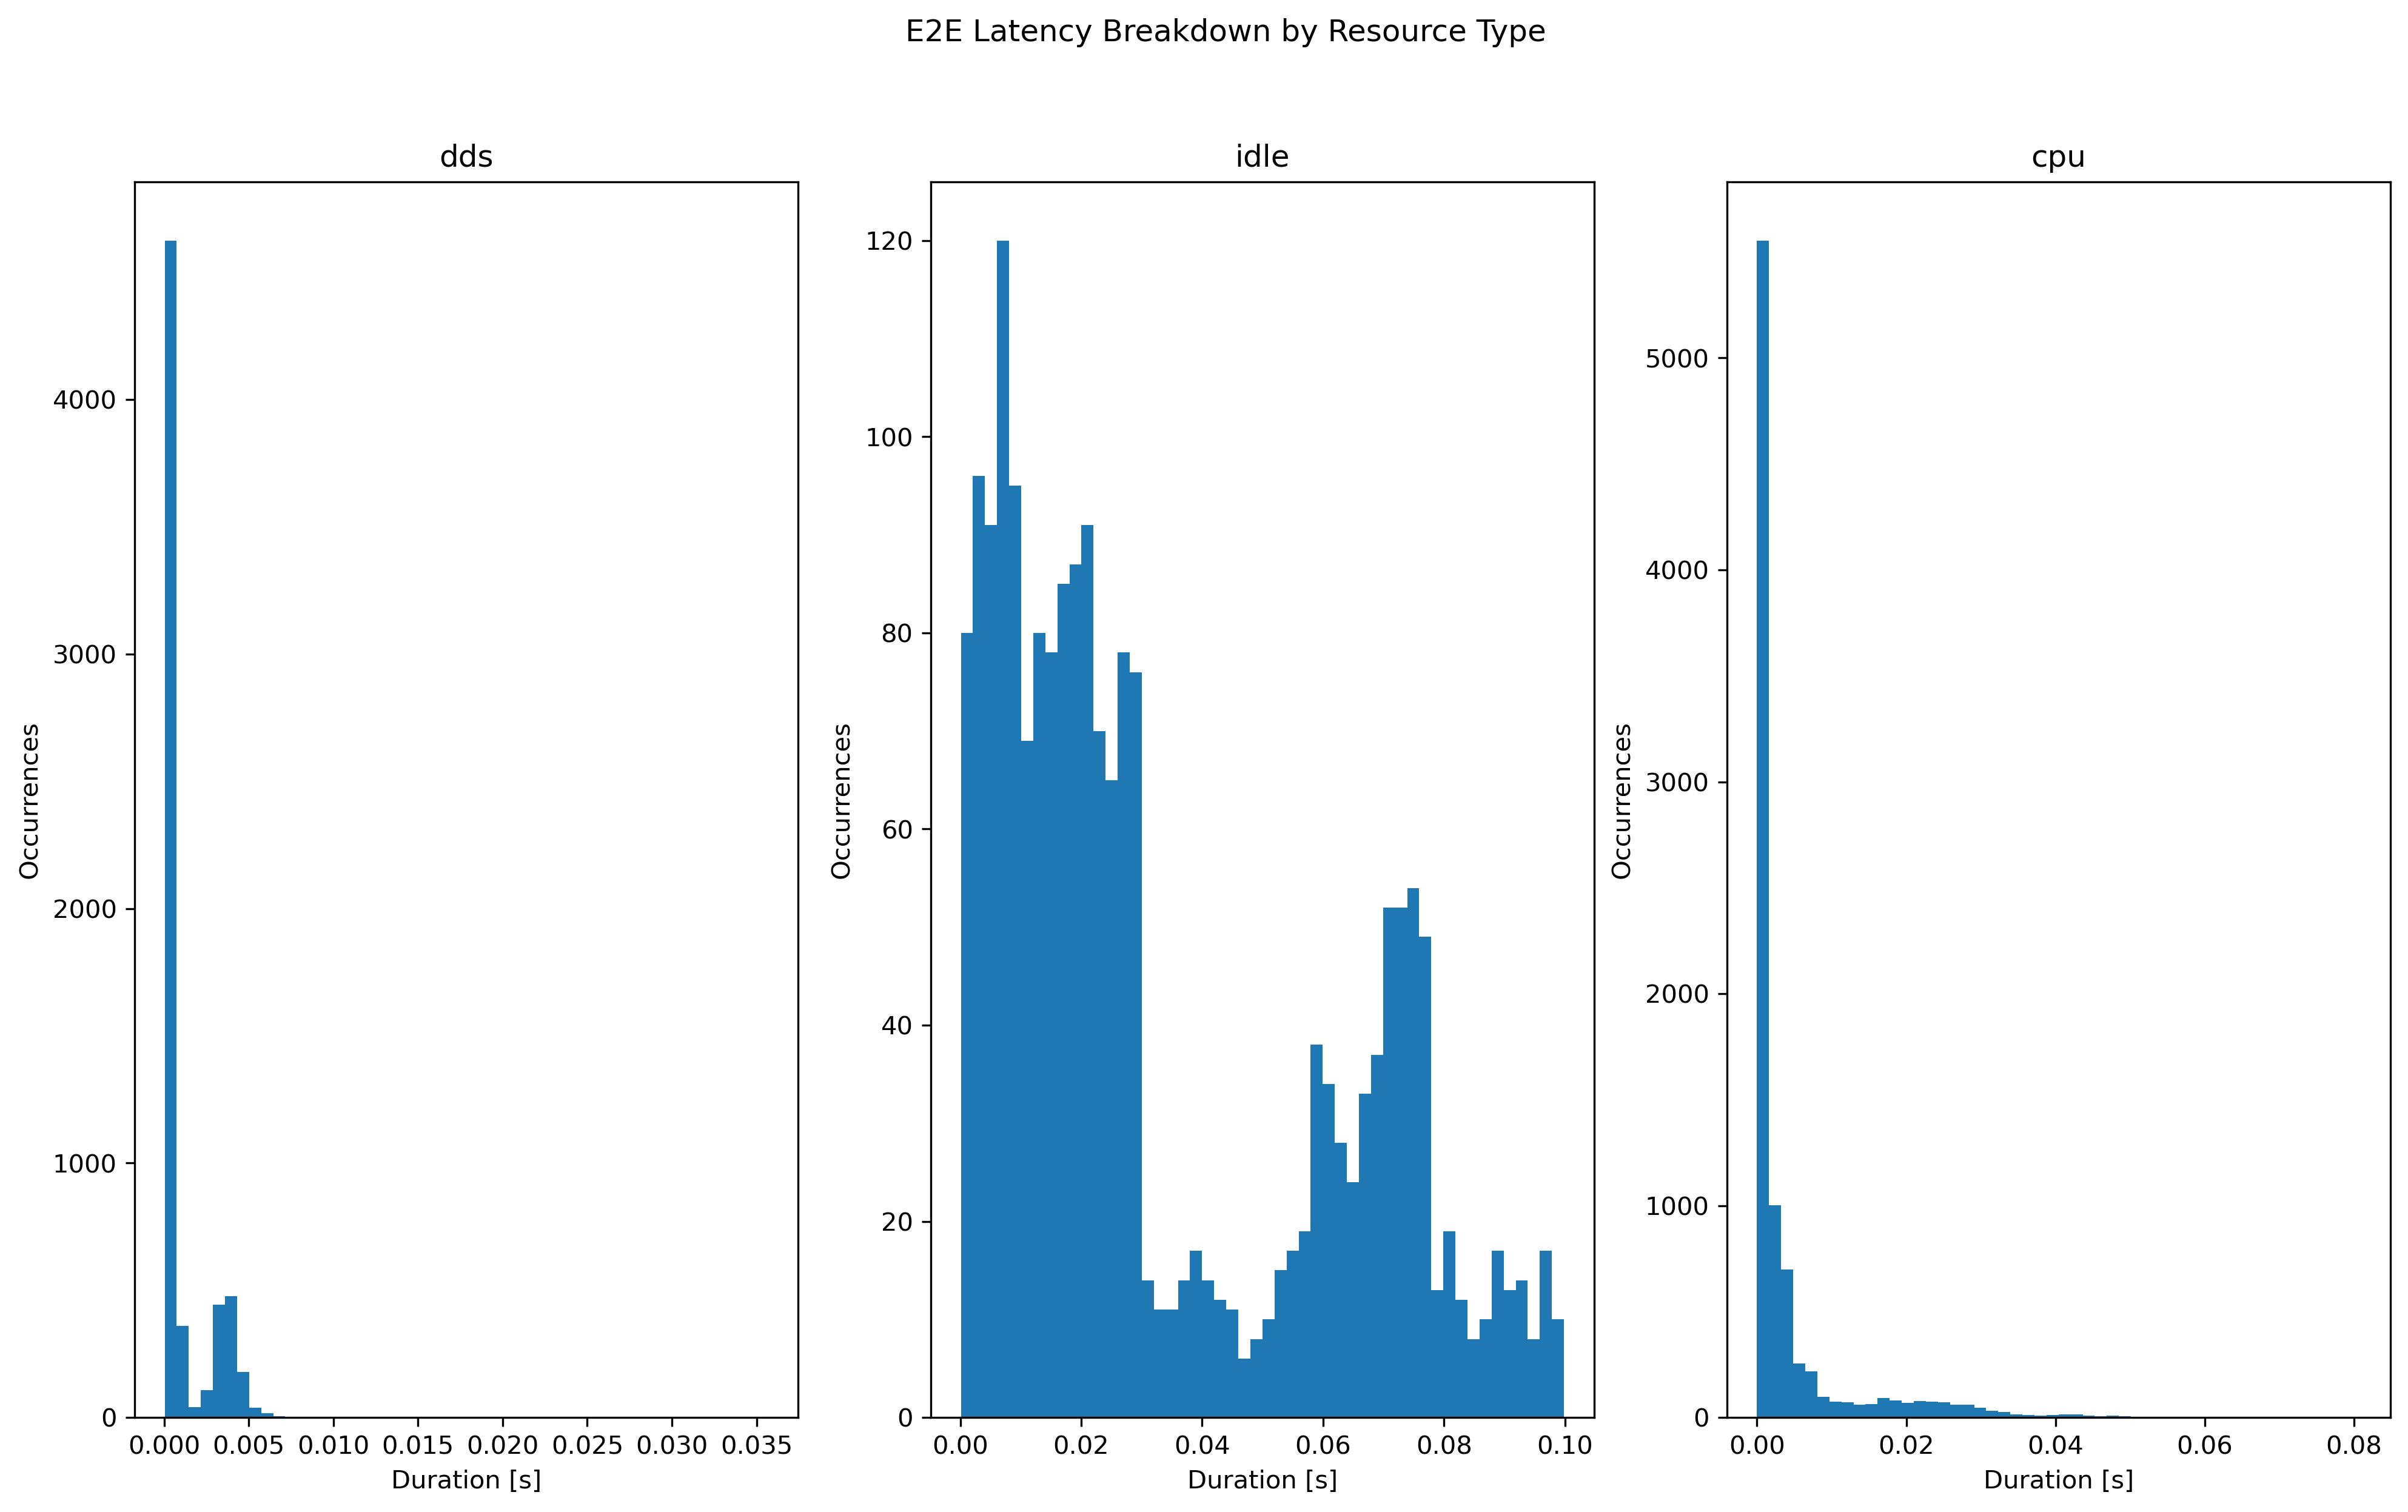

In [15]:
%%skip_if_false E2E_ENABLED
%%skip_if_false E2E_PLOT

##################################################
# Output the chosen DFG path to a file
##################################################

from message_tree.message_tree_algorithms import e2e_latency_breakdown

conv_items = [i for p in e2e_breakdowns for i in p]
with open("out/plot_e2es_path.txt", "w") as f:
    f.write(f"Number of path instances: {len(relevant_dataflows)}\n")
    f.write( "    " + "\n -> ".join(relevant_path.split(" -> ")))
    f.write("\n")

conv_items_unique = set(conv_items)

def e2e_breakdown_type_hist__(items):
    """
    Given a list of e2e breakdown instances of the form `("<type>", <duration>)`, plots a histogram for each encountered
    type.
    """
    plot_types = ("dds", "idle", "cpu")
    #assert all(item.type in plot_types for item in items)

    plt.close("E2E type breakdown histograms")
    fig, axes = plt.subplots(1, 3, num="E2E type breakdown histograms", dpi=300, figsize=(16, 9))
    fig.suptitle("E2E Latency Breakdown by Resource Type")

    for type, ax in zip(plot_types, axes):
        durations = [item.duration for item in items if item.type == type]

        df = pd.Series(durations)
        df.to_csv(f"out/plot_e2es_{type}_portion.csv", header=[f"e2e_latency_{type}_portion_s"], index=False)

        ax.set_title(type)
        ax.hist(durations, bins=50)
        #ax.set_yscale("log")
        ax.set_xlabel("Duration [s]")
        ax.set_ylabel("Occurrences")

    return fig

##################################################
# Plot DDS/idle/computation time histograms
# Histograms show individual latency components
# over all dataflows (de-duplicated)
##################################################

fig = e2e_breakdown_type_hist__(conv_items_unique)
plt.savefig("out/plot_e2e_portions.png")

None


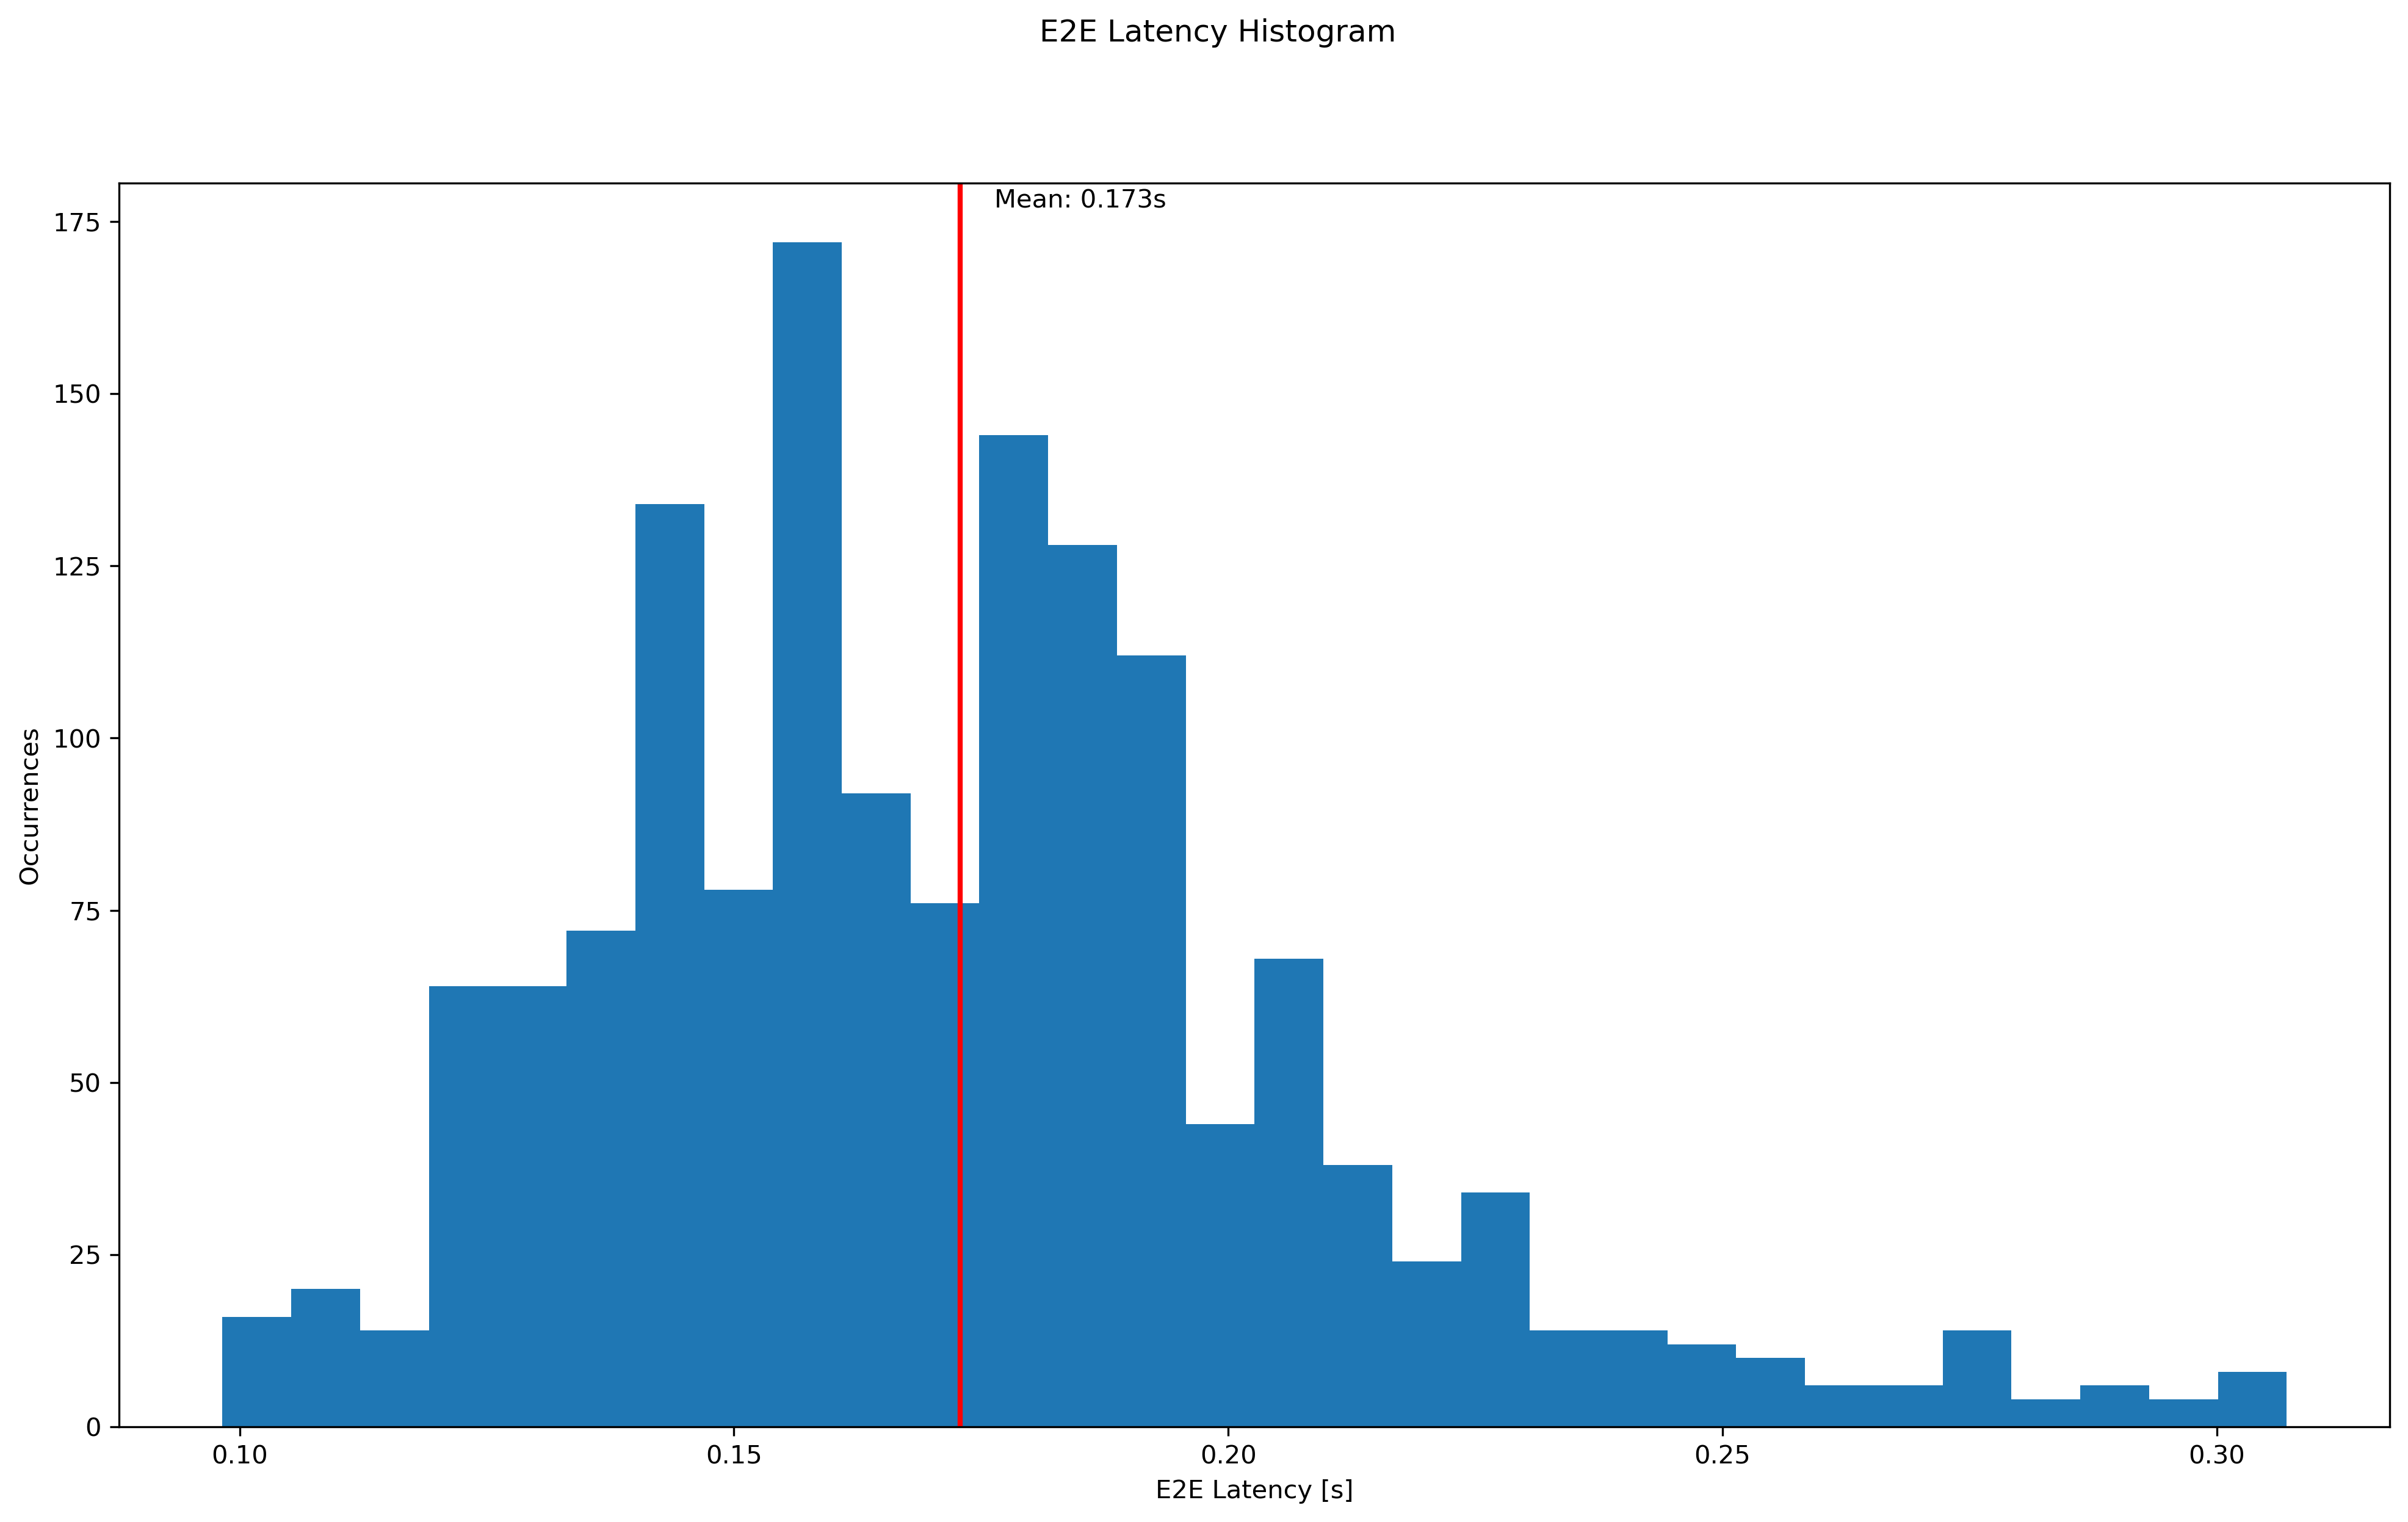

In [16]:
%%skip_if_false E2E_ENABLED
%%skip_if_false E2E_PLOT

##################################################
# Plot histogram of all E2E latencies observed
##################################################

e2es = [path[-1].timestamp - path[0].timestamp for path in relevant_dataflows]

df = pd.Series(e2es)
df.to_csv("out/plot_e2es.csv", index=False, header=["e2e_latency_s"])

plt.close("E2E histogram")
fig, ax = plt.subplots(num="E2E histogram", dpi=300, figsize=(16, 9))
fig.suptitle("E2E Latency Histogram")
ax: plt.Axes
ax.hist(e2es, bins=30)
ax.set_xlabel("E2E Latency [s]")
ax.set_ylabel("Occurrences")
ax.axvline(np.mean(e2es), c="red", linewidth=2)
_, max_ylim = ax.get_ylim()
ax.text(np.mean(e2es) * 1.02, max_ylim * 0.98, 'Mean: {:.3f}s'.format(np.mean(e2es)))
plt.savefig("out/plot_e2es.png")
None

Calculating breakdowns: 100%|██████████| 1492/1492 [00:00<00:00, 34221.62it/s]


27 27


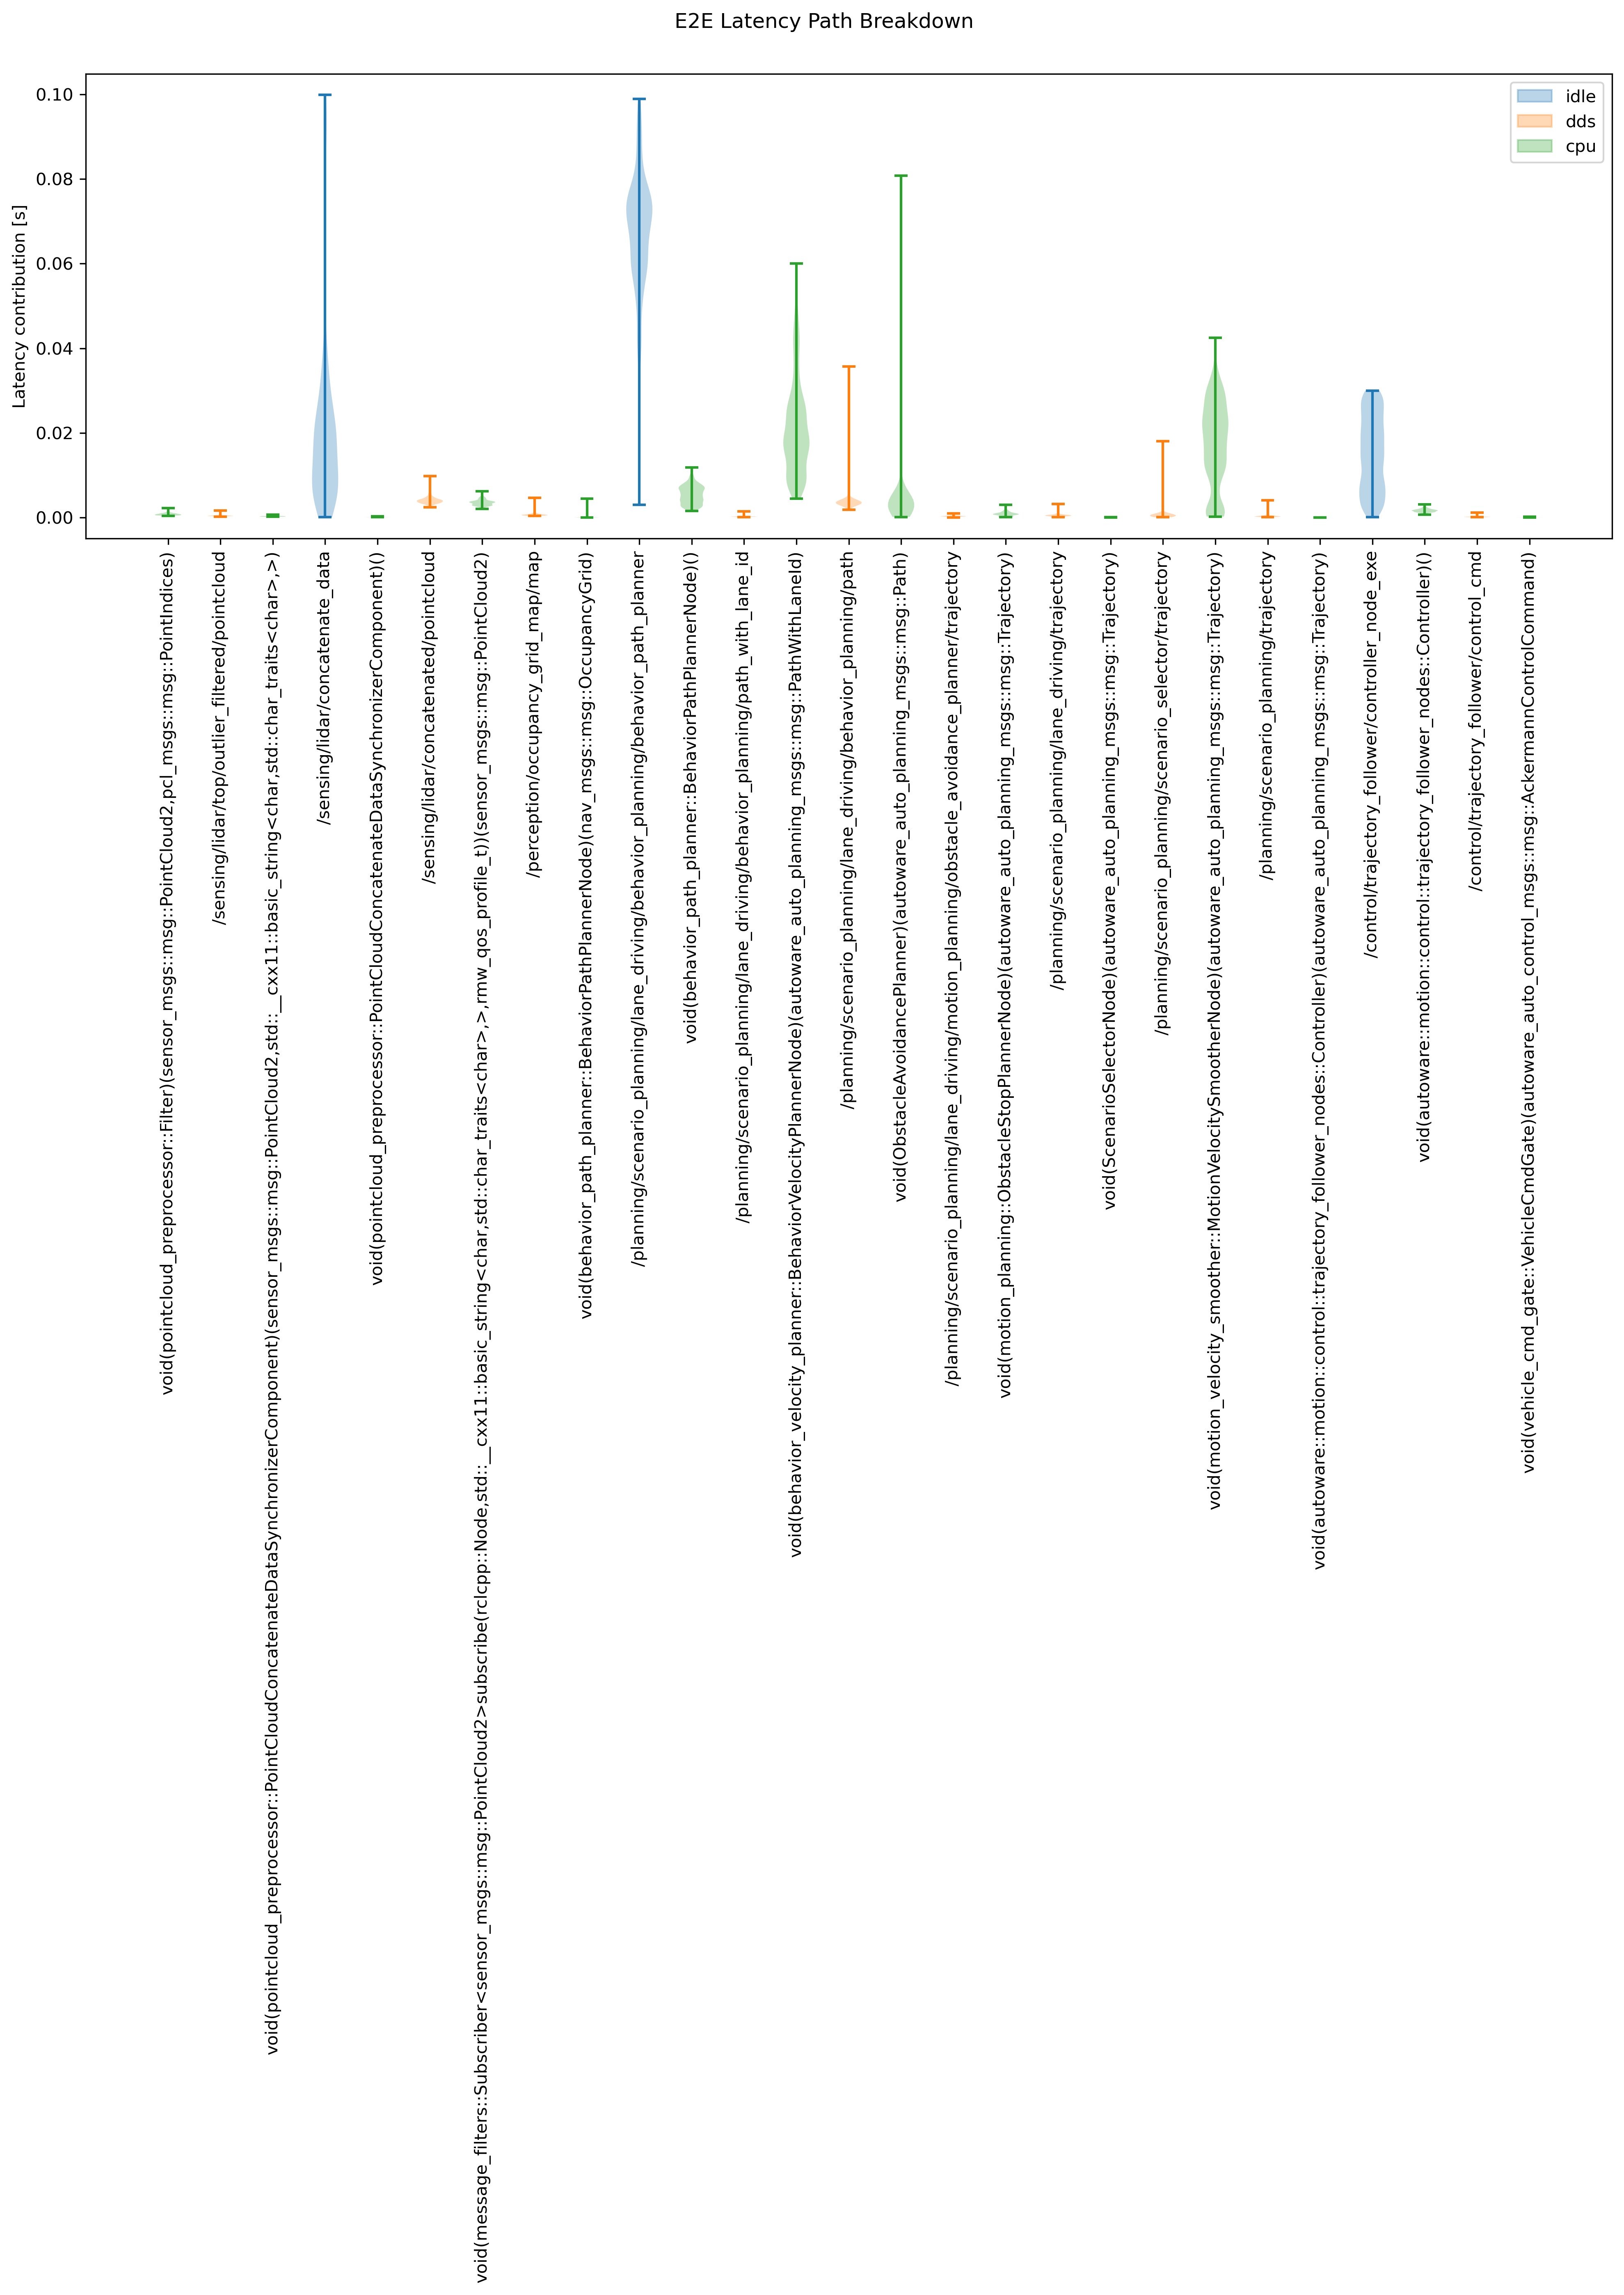

In [34]:
%%skip_if_false E2E_ENABLED
%%skip_if_false E2E_PLOT

from message_tree.message_tree_algorithms import label_latency_item

##################################################
# Plot violin plot of latencies on each station
# of the DFG path (aggregated over all dataflows)
##################################################

plt.close("E2E path breakdown")
fig, ax = plt.subplots(num="E2E path breakdown", dpi=300, figsize=(16, 5))
fig.suptitle("E2E Latency Path Breakdown")
ax: plt.Axes

component_durations = list(zip(*[e2e_latency_breakdown(p) for p in tqdm(relevant_dataflows, desc="Calculating breakdowns")]))
component_latency_items = component_durations
labels = [label_latency_item(item) for item in e2e_latency_breakdown(relevant_dataflows[0])]
types = [item.type for item in e2e_latency_breakdown(relevant_dataflows[0])]
component_durations = [list(map(lambda item: item.duration, d)) for d in component_durations]
print(len(component_durations), len(labels))

import matplotlib.patches as mpatches

legend_entries = []
def add_label(violin, label):
    color = violin["bodies"][0].get_facecolor().flatten()
    legend_entries.append((mpatches.Patch(color=color), label))

for type in ("idle", "dds", "cpu"):
    indices = [i for i, t in enumerate(types) if t == type]
    xs = [component_durations[i] for i in indices]
    vln = ax.violinplot(xs, indices)
    add_label(vln, type)
    for i, x in zip(indices, xs):
        df_out = pd.Series(x)
        df_out.to_csv(f"out/plot_e2es_violin_{i:02d}.csv", index=False, header=["duration_s"])
ax.set_ylabel("Latency contribution [s]")
ax.set_xticks(range(len(labels)), labels, rotation=90)
ax.legend(*zip(*legend_entries))
plt.savefig("out/plot_e2es_violin.png")

df_labels = pd.Series(labels)
df_labels.to_csv("out/plot_e2es_violin_labels.csv", index=False, header=["label"])

df_types = pd.Series(types)
df_types.to_csv("out/plot_e2es_violin_types.csv", index=False, header=["type"])

None

In [29]:
for concat_pc_items in component_latency_items:
    if not isinstance(concat_pc_items[0].location[0], TrPublishInstance):
        continue
    dur_ts_records = [(item.location[0].timestamp, item.duration) for item in concat_pc_items]
    df_dur_ts = pd.DataFrame(dur_ts_records, columns=("timestamp", "duration"))
    df_dur_ts.to_csv(f"dur_ts_{concat_pc_items[0].location[0].publisher.topic_name.replace('/', '__')}.csv", index=False)

In [33]:
indices = [i for i, t in enumerate(types) if t == "cpu"]
xs = [np.array(list(map(lambda item: item.location[0].duration, component_latency_items[i]))) for i in indices]
lbls = [labels[i] for i in indices]

records = [(lbl, x.mean(), x.std(), x.min(), x.max()) for x, lbl in zip(xs, lbls)]
df_cpu = pd.DataFrame(records, columns=["callback", "mean", "std", "min", "max"])
df_cpu.to_csv("out/calc_times.csv", index=False)

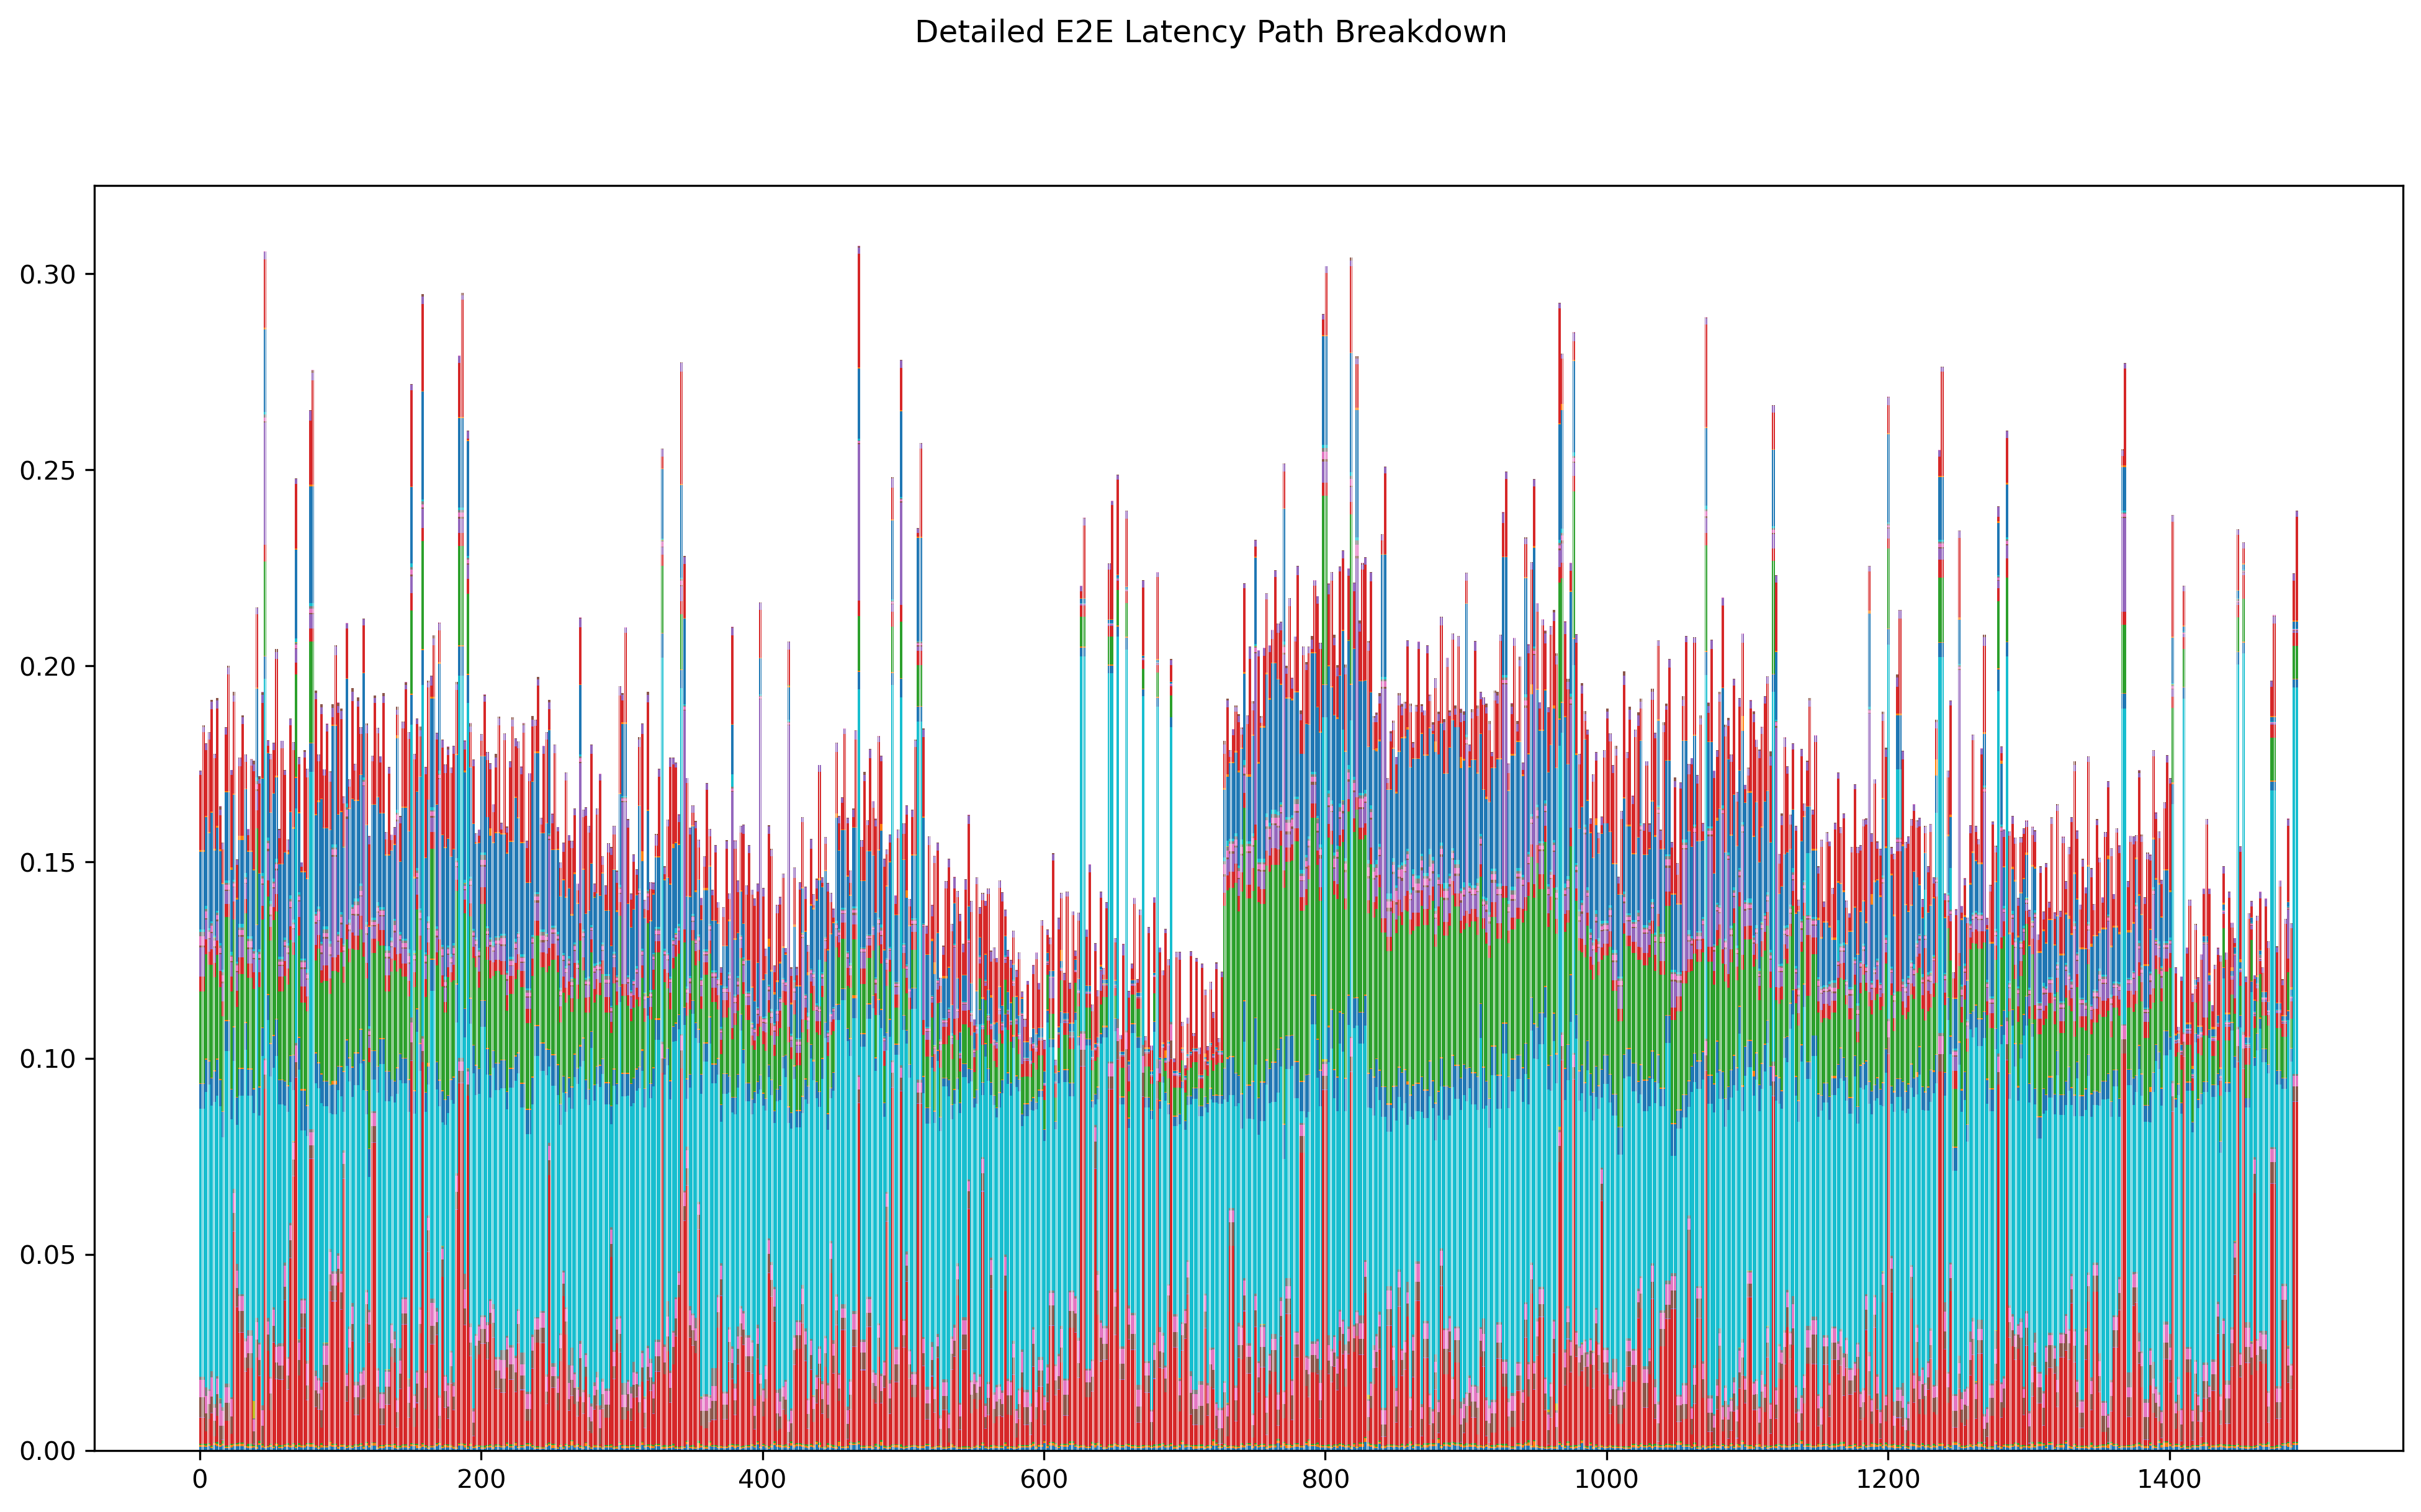

In [18]:
%%skip_if_false E2E_ENABLED
%%skip_if_false E2E_PLOT

from message_tree.message_tree_plots import e2e_breakdown_inst_stack


fig = e2e_breakdown_inst_stack(*e2e_breakdowns)
fig.set_size_inches(16, 9)
fig.set_dpi(300)
None

In [ ]:
%%skip_if_false E2E_ENABLED
%%skip_if_false DEBUG

import pickle

with open("trees.pkl", "wb") as f:
    pickle.dump(trees, f)

In [15]:
ctx = relevant_paths[0][0]._c
topics = ctx.topics

topics_of_interest = [item.publisher.topic_name for item in relevant_dataflows[0] if isinstance(item, TrPublishInstance)]

topic_records = []
for t in topics_of_interest:
    topic_records.append((t, topics.by_name[t].subscriptions[0]))

print(topic_records)

[('/sensing/lidar/top/outlier_filtered/pointcloud', TrSubscription(id=140479461202528, timestamp=1659973557952273201, node_handle=140479460571600, rmw_handle=140479461243872, topic_name='/sensing/lidar/top/outlier_filtered/pointcloud', depth=5)), ('/sensing/lidar/concatenated/pointcloud', TrSubscription(id=140107068367504, timestamp=1659973557827122999, node_handle=140107067792304, rmw_handle=140107068367696, topic_name='/sensing/lidar/concatenated/pointcloud', depth=1)), ('/perception/occupancy_grid_map/map', TrSubscription(id=94693468153792, timestamp=1659973558160675676, node_handle=94693466833888, rmw_handle=94693468215216, topic_name='/perception/occupancy_grid_map/map', depth=1)), ('/planning/scenario_planning/lane_driving/behavior_planning/path_with_lane_id', TrSubscription(id=139977017576848, timestamp=1659973578471689633, node_handle=139977016757536, rmw_handle=139977017582464, topic_name='/planning/scenario_planning/lane_driving/behavior_planning/path_with_lane_id', depth=1))